In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error as mse, classification_report
from sklearn.model_selection import train_test_split

# Dataset 
- UCI housing 

In [2]:
housing_names = ["f" + str(i) for i in range(13)] + ["price"]
housing = pd.read_fwf("housing.fwf", names=housing_names)

In [3]:
print("housing size:",housing.shape)

housing size: (506, 14)


In [4]:
housing.sample(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,price
276,0.10469,40.0,6.41,1,0.447,7.267,49.0,4.7872,4,254.0,17.6,389.25,6.05,33.2
358,5.20177,0.0,18.10,1,0.770,6.127,83.4,2.7227,4,666.0,20.2,395.43,11.48,22.7
153,2.14918,0.0,19.58,0,0.871,5.709,98.5,1.6232,5,403.0,14.7,261.95,15.79,19.4


# Preprocessing

## Normalization

In [5]:
scaler = MinMaxScaler()
housing = scaler.fit_transform(housing)

## Train test split

In [6]:
X_housing, y_housing = housing[:, :-1], housing[:, -1]
print(X_housing.shape, y_housing.shape)

(506, 13) (506,)


In [7]:
x_train_housing, x_test_housing, y_train_housing, y_test_housing = train_test_split(X_housing, y_housing, train_size=0.8)

In [8]:
x_train_housing.shape, x_test_housing.shape

((404, 13), (102, 13))

In [9]:
def plot_history(history, metrics, model_name:str):
    fig = plt.figure(figsize=[8, 4])
    for metric in metrics:
        plt.plot(history.history[metric], label='train '+ metric)
        plt.plot(history.history['val_' + metric], label='val ' + metric)        
    plt.legend()    
    plt.xlabel('epoch')
    plt.ylabel(" ".join(metrics))
    plt.xticks(list(range(0, len(history.history[metrics[0]]), 2)))
    plt.grid(visible=True)
    plt.title(model_name + " training history [" + " ".join(metrics) + "]")

## Modeling

### 1. Decision Tree

In [10]:
from sklearn.tree import DecisionTreeRegressor

In [11]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train_housing, y_train_housing)

DecisionTreeRegressor()

In [12]:
y_pred_dtr = dt_reg.predict(x_test_housing)
dtr_result = mse(y_pred=y_pred_dtr, y_true=y_test_housing)

In [13]:
def sre(result):
    return f"mse: {result:.4f}"

In [14]:
print("Decision Tree -", sre(dtr_result))

Decision Tree - mse: 0.0069


### 2. KNN 

In [15]:
from sklearn.neighbors import KNeighborsRegressor as KNR

In [16]:
knr = KNR(n_neighbors=8)

In [17]:
knr.fit(x_train_housing, y_train_housing)

KNeighborsRegressor(n_neighbors=8)

In [18]:
y_pred_knr = knr.predict(x_test_housing)
knr_result = mse(y_pred_knr, y_test_housing)

In [19]:
print("KNN -", sre(knr_result))

KNN - mse: 0.0150


### 3. Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [21]:
lnr = LinearRegression()
lnr.fit(x_train_housing, y_train_housing)

LinearRegression()

In [22]:
y_pred_lnr = lnr.predict(x_test_housing)
lnr_result = mse(y_pred_lnr, y_test_housing)
print(lnr_result)

0.010967758990156869


In [23]:
print("Linear Regression -", sre(lnr_result))

Linear Regression - mse: 0.0110


### 3. SVM

In [24]:
from sklearn.svm import SVR

In [25]:
svm = SVR()
svm.fit(x_train_housing, y_train_housing)

SVR()

In [26]:
y_pred_svm = svm.predict(x_test_housing)
svm_result = mse(y_pred=y_pred_svm, y_true=y_test_housing)
print("SVM -", sre(svm_result))

SVM - mse: 0.0077


### 4. Random Forest

In [27]:
from sklearn.ensemble import  RandomForestRegressor

In [28]:
rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(x_train_housing, y_train_housing)

RandomForestRegressor(n_estimators=10)

In [29]:
y_pred_rfr = rfr.predict(x_test_housing)
rfr_result = mse(y_pred_rfr, y_test_housing)
print("Random Forest - ",sre(rfr_result))

Random Forest -  mse: 0.0063


### 5. MLP

In [30]:
mlp = Sequential([
    Dense(units=16, input_dim= X_housing.shape[1], activation="relu", name="fc1"),
    Dense(units=8, activation="relu", name="fc2"),
    Dense(units=1, name="output")
])
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                224       
                                                                 
 fc2 (Dense)                 (None, 8)                 136       
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [31]:
mlp.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mse"]
)

In [32]:
history_mlp = mlp.fit(x_train_housing, y_train_housing, epochs=35, verbose=0, validation_split=0.2)

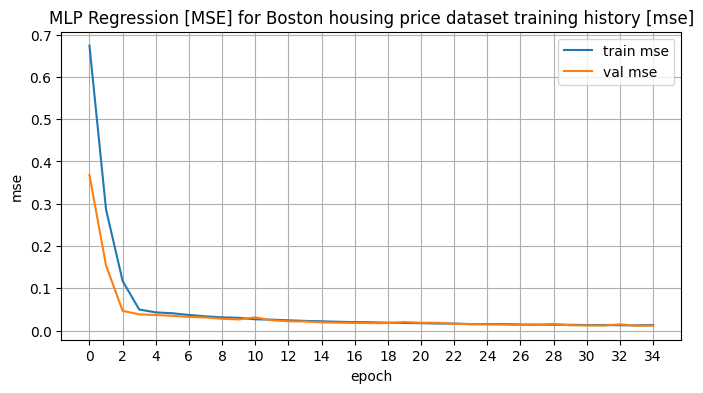

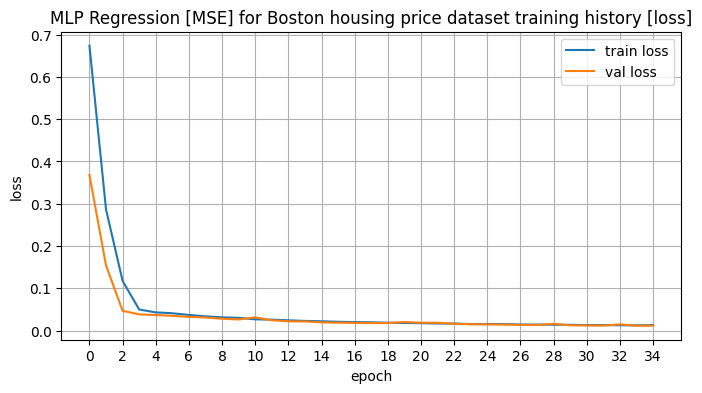

In [33]:
plot_history(history_mlp, metrics=["mse"], model_name="MLP Regression [MSE] for Boston housing price dataset")
plot_history(history_mlp, metrics=["loss"], model_name="MLP Regression [MSE] for Boston housing price dataset")

In [34]:
result_mlp = mlp.evaluate(x_test_housing, y_test_housing)

4/4 [==============================] - 0s 4ms/step - loss: 0.0142 - mse: 0.0142


## Result

In [37]:
result = {
    dtr_result: "Decision Tree",
    knr_result:"kNN",
    lnr_result:"Linear Regression",
    svm_result:"SVM",
    rfr_result:"Random Forest",
    result_mlp[1]:"MLP"
}

Text(0.5, 1.0, 'Regression task result - MSE metric (lower is better)')

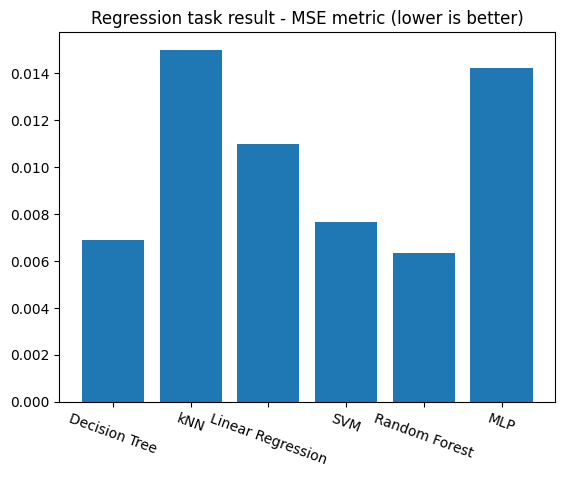

In [38]:
plt.bar(result.values(), result.keys())
plt.xticks(rotation=-20)
plt.title("Regression task result - MSE metric (lower is better)")

In [48]:
df = pd.DataFrame(result.items())
df.style.highlight_min(color = 'green', axis = 0)

,0,1
0,0.006909,Decision Tree
1,0.014995,kNN
2,0.010968,Linear Regression
3,0.007682,SVM
4,0.006340,Random Forest
5,0.014221,MLP
